# Performance of annotation-enhanced fine-mapping

Let's skip the formalities and dive directly into the results: power, false discovery proportion, top hit rate, size and purity.

## Results

In [2]:
readRDS("~/GIT/github/annotation-finemap-dsc/analysis/xh_grant/0820.summary.rds")

,Sample size,Annotation effect,DAP Power,aDAP Power,DAP FDP,aDAP FDP,DAP top hit rate,aDAP top hit rate,DAP size,aDAP size,DAP purity,aDAP purity
1,50000,"c(3,0.1336)",0.0679,0.0699,0.007,0.0201,0.4336,0.5034,7,7,0.9883,0.9862
2,50000,"list(c(3,55),c(0.1269,0.00668))",0.0665,0.0722,0.0071,0.0066,0.4071,0.5461,7,6,0.9883,0.9858
3,80000,"c(3,0.1336)",0.1402,0.1407,0.0101,0.0134,0.4797,0.557,6.5,6,0.9881,0.9882
4,80000,"list(c(3,55),c(0.1269,0.00668))",0.1392,0.1488,0.0034,0.0064,0.4795,0.5847,7,6,0.9879,0.9867
5,150000,"c(3,0.1336)",0.2407,0.2464,0.0059,0.0039,0.5494,0.6015,5,4,0.9911,0.9905
6,150000,"list(c(3,55),c(0.1269,0.00668))",0.2388,0.2579,0.004,0.0037,0.511,0.6654,6,4,0.9903,0.9888


The error bar should be around $\sigma = 0.01$ in length ($\sqrt{p(1-p)/N}$ where $N$ is 2,090). I plot $2\sigma$.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

m1, m2, m3 = 'No annotation', 'ATAC-seq', 'ATAC-seq + ASCA'
s1, s2, s3 = '50K', '80K', '150K'
data = pd.DataFrame({'method': [m1,m2,m3] * 3,
                    'sample_size': [s1] * 3 + [s2] * 3 + [s3] * 3,
                    'thr': [0.42, 0.50, 0.55, 0.48, 0.55, 0.58, 0.53, 0.60, 0.67]})
print(data)

            method sample_size   thr
0    No annotation         50K  0.42
1         ATAC-seq         50K  0.50
2  ATAC-seq + ASCA         50K  0.55
3    No annotation         80K  0.48
4         ATAC-seq         80K  0.55
5  ATAC-seq + ASCA         80K  0.58
6    No annotation        150K  0.53
7         ATAC-seq        150K  0.60
8  ATAC-seq + ASCA        150K  0.67


In [4]:
%get data --from Python3

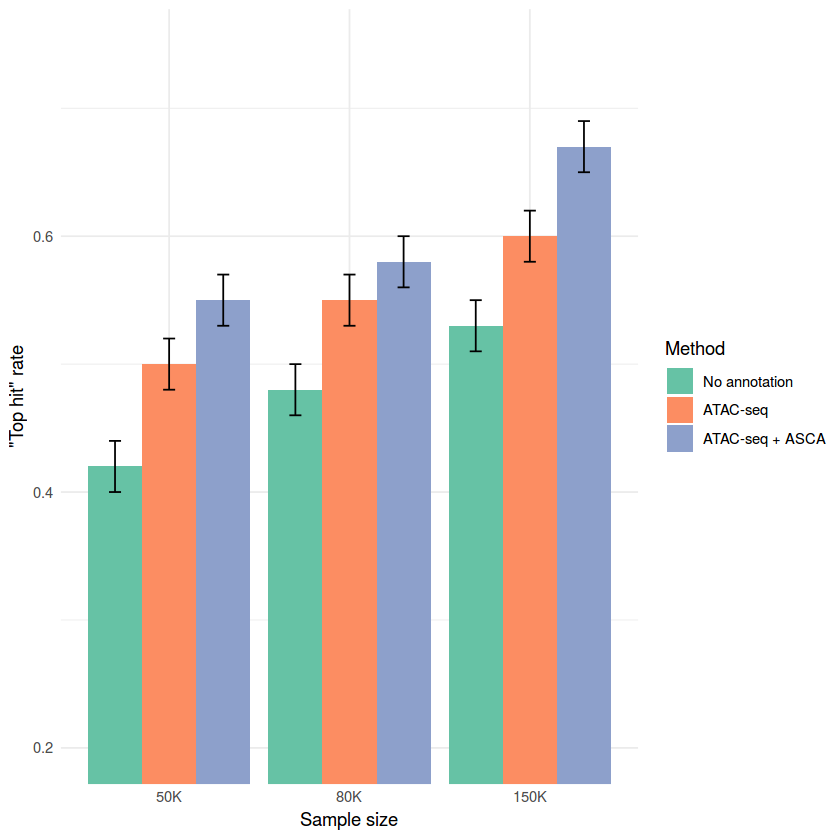

In [5]:
data$sd = 0.02
data$method = factor(data$method, levels = c('No annotation', 'ATAC-seq', 'ATAC-seq + ASCA'))
data$sample_size <- factor(data$sample_size, levels = c('50K', '80K', '150K'))
library(ggplot2)
p <- ggplot(data, aes(x=sample_size, y=thr, fill=method)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_errorbar(aes(ymin=thr-sd, ymax=thr+sd), width=.2, position=position_dodge(.9)) 
p + scale_fill_brewer(palette="Set2") + theme_minimal() + xlab('Sample size') + 
    ylab('"Top hit" rate') + labs(fill="Method") + coord_cartesian(ylim=c(0.2,0.75))
# library(wesanderson)
# p + scale_fill_manual(values=wes_palette(n=3, name="GrandBudapest2")) + theme_minimal()

Workflow below was used to obtain this table.

## Results data processing

To get the results,

```
sos run report.ipynb
```

In [ ]:
[global]
parameter: cwd = path('~/GIT/github/annotation-finemap-dsc/analysis')
parameter: date = '0820'
dirname = path(f'{cwd:a}/xh_grant/')

In [ ]:
[default_1]
output: f'{dirname}/{date}.out.rds'
R: expand = '${ }', workdir = cwd
    out = dscrutils::dscquery(${dirname:br}, target = "sample_region.dataset simulate_prior.eparam simulate_z simulate_z.N fit evaluate", load.pkl = TRUE)
    saveRDS(out, ${_output:r})

In [ ]:
[default_2]
output: f'{_input:nn}.summary.rds'
R: expand = '${ }', workdir = cwd
    options(warn=2)
    dat = readRDS(${_input:r})
    ann = as.character(unique(dat$simulate_prior.eparam))
    sample_size = unique(dat$simulate_z.N)
    data_sets = unique(dat$sample_region.dataset)
    dap = list()
    dapa = list()
    res = NULL
    for (n in sample_size) {
        for (a in ann) {
          s = paste0(as.character(n), '_', as.character(a))
          dap[[s]] = list(power_d = 0, power_n = 0, fdp_d = 0, fdp_n = 0, hit_d = 0, hit_n = 0, size = vector(), purity = vector())
          dapa[[s]] = list(power_d = 0, power_n = 0, fdp_d = 0, fdp_n = 0, hit_d = 0, hit_n = 0, size = vector(), purity = vector())
          for (d in data_sets) {
              ## for DAP
              fn = dat[which(dat$fit == 'dap' & dat$simulate_prior.eparam == a & dat$simulate_z.N == n & dat$sample_region.dataset == d), c('simulate_z.output.file', 'evaluate.output.file')][1,]
              tmp = readRDS(paste0("${dirname}/", fn[2], ".rds"))
              L = readRDS(paste0("${dirname}/", fn[1], ".rds"))$L
              for (i in 1:length(tmp$is_recovered)) {
                  # power
                  dap[[s]]$power_d = dap[[s]]$power_d + ifelse(tmp$is_recovered[[i]][1] == 'failed', 0, sum(tmp$is_recovered[[i]]))
                  dap[[s]]$power_n = dap[[s]]$power_n + L[[i]]
                  if (tmp$is_cs_true[[i]][1] != 'failed') {
                      # fdp
                      dap[[s]]$fdp_d = dap[[s]]$fdp_d + length(tmp$is_cs_true[[i]]) - sum(tmp$is_cs_true[[i]])
                      dap[[s]]$fdp_n = dap[[s]]$fdp_n + length(tmp$is_cs_true[[i]])
                      # top hit of cluster is signal
                      dap[[s]]$hit_d = dap[[s]]$hit_d + sum(tmp$is_top_true[[i]])
                      dap[[s]]$hit_n = dap[[s]]$hit_n + length(tmp$is_top_true[[i]])
                      # size
                      dap[[s]]$size = c(dap[[s]]$size, tmp$size[[i]])
                      # purity
                      dap[[s]]$purity = c(dap[[s]]$purity, tmp$purity[[i]])
                  }
              }
              ## for DAP with annotation
              fn = dat[which(dat$fit == 'dapa' & dat$simulate_prior.eparam == a & dat$simulate_z.N == n & dat$sample_region.dataset == d), c('simulate_z.output.file', 'evaluate.output.file')][1,]
              tmp = readRDS(paste0("${dirname}/", fn[2], ".rds"))
              L = readRDS(paste0("${dirname}/", fn[1], ".rds"))$L
              for (i in 1:length(tmp$is_recovered)) {
                  # power
                  dapa[[s]]$power_d = dapa[[s]]$power_d + ifelse(tmp$is_recovered[[i]][1] == 'failed', 0, sum(tmp$is_recovered[[i]]))
                  dapa[[s]]$power_n = dapa[[s]]$power_n + + L[[i]]
                  if (tmp$is_cs_true[[i]][1] != 'failed') {
                      # fdp
                      dapa[[s]]$fdp_d = dapa[[s]]$fdp_d + length(tmp$is_cs_true[[i]]) - sum(tmp$is_cs_true[[i]])
                      dapa[[s]]$fdp_n = dapa[[s]]$fdp_n + length(tmp$is_cs_true[[i]])
                      # top hit in cluster is signal
                      dapa[[s]]$hit_d = dapa[[s]]$hit_d + sum(tmp$is_top_true[[i]])
                      dapa[[s]]$hit_n = dapa[[s]]$hit_n + length(tmp$is_top_true[[i]])
                      # size
                      dapa[[s]]$size = c(dapa[[s]]$size, tmp$size[[i]])
                      # purity
                      dapa[[s]]$purity = c(dapa[[s]]$purity, tmp$purity[[i]])
                  }
              }
          }
          dap[[s]]$power = dap[[s]]$power_d / dap[[s]]$power_n
          dap[[s]]$fdp = dap[[s]]$fdp_d / dap[[s]]$fdp_n    
          dap[[s]]$hit = dap[[s]]$hit_d / dap[[s]]$hit_n
          dap[[s]]$size = median(dap[[s]]$size)
          dap[[s]]$purity = mean(dap[[s]]$purity)
          #
          dapa[[s]]$power = dapa[[s]]$power_d / dapa[[s]]$power_n
          dapa[[s]]$fdp = dapa[[s]]$fdp_d / dapa[[s]]$fdp_n    
          dapa[[s]]$hit = dapa[[s]]$hit_d / dapa[[s]]$hit_n
          dapa[[s]]$size = median(dapa[[s]]$size)
          dapa[[s]]$purity = mean(dapa[[s]]$purity)
          line = c(n, a, round(c(dap[[s]]$power, dapa[[s]]$power, dap[[s]]$fdp, dapa[[s]]$fdp, dap[[s]]$hit, dapa[[s]]$hit, dap[[s]]$size, dapa[[s]]$size, dap[[s]]$purity, dapa[[s]]$purity), 4))
          if (is.null(res)) {
            res = line
          } else {
            res = rbind(res, line)
          }
        }
    }
    colnames(res) = c('Sample size', 'Annotation effect', 'DAP Power', 'aDAP Power', 'DAP FDP', 'aDAP FDP', 'DAP top hit rate', 'aDAP top hit rate', 'DAP size', 'aDAP size', 'DAP purity', 'aDAP purity')
    rownames(res) = 1:nrow(res)
    saveRDS(res, ${_output:r})